# Simplification in CFS

## Triangle Pruning (String Pulling)
Lets fill a polygon


In [2]:
import numpy as np
import cfsrouting as cfs
from matplotlib import pyplot as plt
from skimage import exposure



## Step 1: Prepare a Path Library in Model Scenario

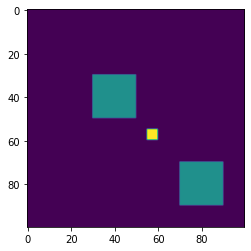

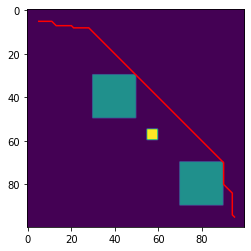

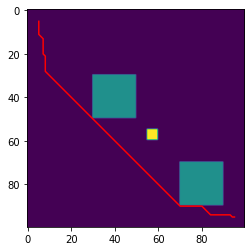

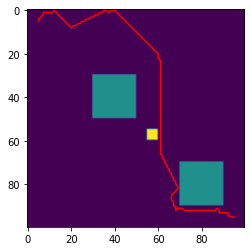

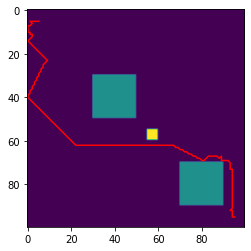

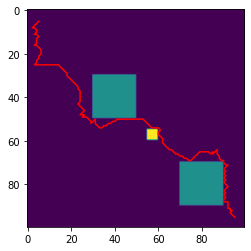

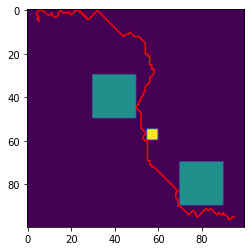

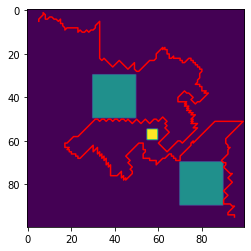

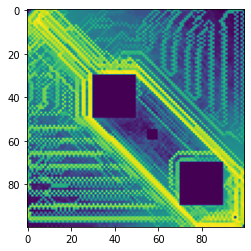

In [3]:
m = np.zeros(100*100).reshape(-1,100).astype(np.uint8);   
m[30:50,30:50] = 1
m[55:60,55:60] = 2
m[70:90,70:90] = 1
plt.imshow(m)
handle = cfs.graphFromBitmap(m,0)
pathlib = []
for _ in range(2000):
    cfs.dijkstra(handle, [5,5])
    path = cfs.getpath(handle, [95,95],2).reshape(-1,2)
    # try to classify
    skip = False
    for homotopy_class_representative in pathlib:
        poly = np.vstack([path,np.flipud(homotopy_class_representative)])
        if cfs.empty(m,poly,0): # Not a new homotopy class
            skip = True
            break
    if skip:
        continue
    pathlib.append(path)
    plt.figure()
    plt.imshow(m)
    plt.plot(path[:,0],path[:,1], color="red")

n = m.copy().astype(np.double)
cfs.getweights(handle,n)
plt.figure()
n[np.where(n==0)]=1
n = exposure.equalize_hist(np.log(n), 1000)
plt.imshow(n)


In [4]:
def simplify_step(m, path):
    # cut out longest triangle
    last_good_triangle = None
    for i in range(1,path.shape[0]-1):
        for j in range(i+1,path.shape[0]-2):
            triangle = np.vstack([path[0:i,:], path[(j+1):,:]])
            polygon = np.vstack([path, np.flipud(triangle)])
            empty = cfs.empty(m,polygon.astype(np.double),0)
    #        print(i,j,empty)
            if empty and last_good_triangle is None:
                last_good_triangle = triangle # record first working triangle
            if not empty and last_good_triangle is not None: # already found one but not empty
                plt.imshow(m)
                plt.plot(last_good_triangle[:,0],last_good_triangle[:,1])
                plt.show()
                return last_good_triangle
    print("Fallen Angel: %s" % str(last_good_triangle)[:10])
    return None
            
def bresenham(x0, y0, x1, y1):
    "Bresenham's line algorithm"
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x1:
            yield x, y
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y1:
            yield(x, y)
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy        
    yield (x, y)

def length(t):
    # compute euclidean length of trajectory
    x = np.diff(t, axis=0)
    return np.sqrt(np.sum(x*x))
    
    
    
def random_simplify_step(m, path, sigma):
    # longer triangles first?
    i=0; j=0
    while i == j or j >= path.shape[0]:
        delta = int(np.abs(np.random.uniform(0,sigma)))
        i = int(np.random.uniform(0,path.shape[0]))
        j = int(i+delta)
    head = path[0:i,:]
    line = np.vstack([np.array(x) for x in bresenham(path[i,0],path[i,1],path[j,0], path[j,1])])
    tail = path[(j):,:]
    triangle = np.vstack([head,line,tail])
    polygon  = np.vstack([path, np.flipud(triangle)])
    empty   = cfs.empty(m,polygon.astype(np.double),0)
    if empty:
        return triangle
    else:
        return path
           
# run      
def shortest_path_in_homotopy(path,n_steps = 5000, plotting=False):
    for _ in range(n_steps):
        step = random_simplify_step(m,path, path.shape[0])
        if length(step) < length(path):
            if plotting:
                plt.imshow(m)
                plt.plot(step[:,0], step[:,1])
                plt.show()
            
            path=step
    return path


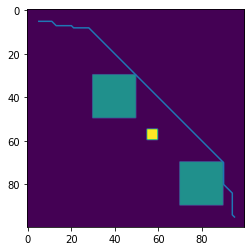

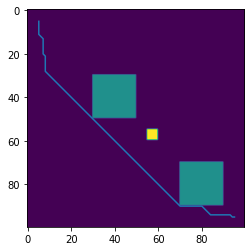

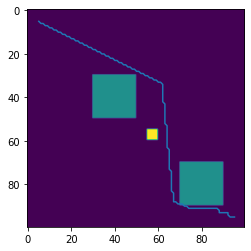

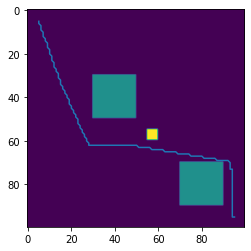

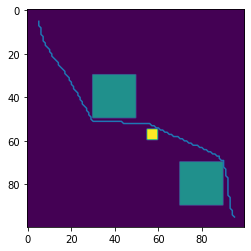

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in uint_scalars


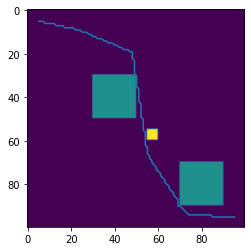

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in uint_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in uint_scalars


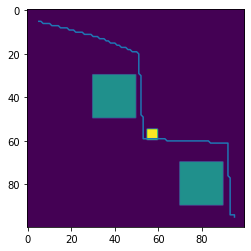

In [36]:

for x in pathlib:
    p = shortest_path_in_homotopy(x)
    plt.imshow(m)
    plt.plot(p[:,0], p[:,1])
    plt.show()